self.supplier_sort [0, 2, 3, 4, 5, 1]
sort supplier:  [(Supplier: 0, 116, 34), (Supplier: 2, 116, 34), (Supplier: 3, 116, 34), (Supplier: 4, 116, 34), (Supplier: 5, 116, 34), (Supplier: 1, 116, 33)]
sort distance:  [0, 0, 0, 0, 0, 111]
self.supplier_sort [0, 2, 3, 4, 5, 1]
sort supplier:  [(Supplier: 0, 116, 34), (Supplier: 2, 116, 34), (Supplier: 3, 116, 34), (Supplier: 4, 116, 34), (Supplier: 5, 116, 34), (Supplier: 1, 116, 33)]
sort distance:  [0, 0, 0, 0, 0, 111]
self.supplier_sort [0, 2, 3, 4, 5, 1]
sort supplier:  [(Supplier: 0, 116, 34), (Supplier: 2, 116, 34), (Supplier: 3, 116, 34), (Supplier: 4, 116, 34), (Supplier: 5, 116, 34), (Supplier: 1, 116, 33)]
sort distance:  [0, 0, 0, 0, 0, 111]
self.supplier_sort [0, 2, 3, 4, 5, 1]
sort supplier:  [(Supplier: 0, 116, 34), (Supplier: 2, 116, 34), (Supplier: 3, 116, 34), (Supplier: 4, 116, 34), (Supplier: 5, 116, 34), (Supplier: 1, 116, 33)]
sort distance:  [91, 91, 91, 91, 91, 202]
self.supplier_sort [0, 2, 3, 4, 5, 1]
sort supplier

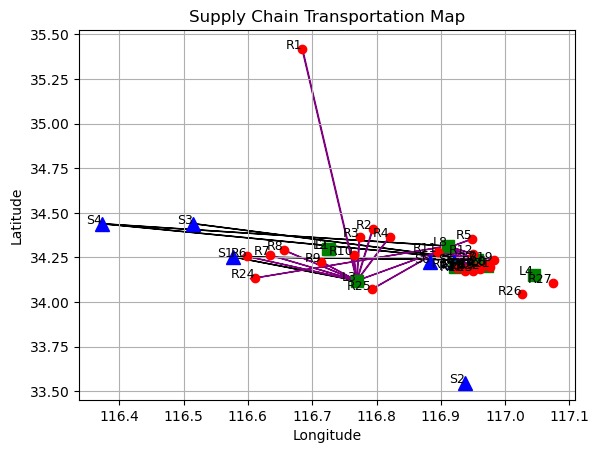

In [1]:
import numpy as np
import copy

from data import cos34, per_cost, per_stockout_cost, per_storage_cost, days
from data import  SupplyContainer, DemandsContainer, DistributionContainer

from draw import Draw



class GA:
    def __init__(self) -> None:
        self.supplier_containers = SupplyContainer()          # 供应商
        self.distribution_containers = DistributionContainer()  # 配送中心
        self.demands_container = DemandsContainer()            # 零售商

        self.distribution_supplier_matrix = None
        self.demand_distribution_matrix = []

    def init_compute(self):
        """
        初始化一些计算过程
        """
        # 计算每个配送中心 的最佳供应商
        for distribution in self.distribution_containers.distributions:
            distribution.compute_supplier_sort(self.supplier_containers.suppliers)
        
        # 计算每个零售商的最佳配送中心
        for demand in self.demands_container.demands:
            demand.compute_distribution_sort(self.distribution_containers.distributions)

        # 一个二维数组的矩阵，计算配送中心到供应商的距离
        self.distribution_supplier_matrix = []
        for distribution in self.distribution_containers.distributions:
            self.distribution_supplier_matrix.append([distribution.addr.distance(supplier.addr) for supplier in self.supplier_containers.suppliers])

        # 一个二维数组的矩阵，计算配送中心到零售商的距离
        for demand in self.demands_container.demands:
            self.demand_distribution_matrix.append([demand.addr.distance(distribution.addr) for distribution in self.distribution_containers.distributions])

    def fitness(self, individual):
        supplier_to_distribution, distribution_to_demand, db_storage, dd_stockout = self.get_plan(individual)
        tran_cost = self.compute_tran_cost(supplier_to_distribution, distribution_to_demand) * days
        construction_cost = self.compute_construction_cost(individual)
        storage_cost = sum(db_storage) * per_storage_cost * days
        stockout_cost = sum(dd_stockout) * per_stockout_cost * days
        all_cost = sum([tran_cost, construction_cost, storage_cost, stockout_cost])
        print("tran_cost: ", tran_cost)
        print("construction_cost: ", construction_cost)
        print("storage_cost: ", storage_cost)
        print("stockout_cost: ", stockout_cost)
        print("all cost: ", all_cost)
        return all_cost

    def compute_tran_cost(self, supplier_to_distribution, distribution_to_demand):
        """
        计算运输成本

        Args:
            supplier_to_distribution (_type_): _description_
            distribution_to_demand (_type_): _description_
        """
        cost = 0
        for (s_i, d_i), num in supplier_to_distribution.items():
            cost += num * self.distribution_supplier_matrix[d_i][s_i] * per_cost

        for (d_i, dd_i), num in distribution_to_demand.items():
            cost += num * self.demand_distribution_matrix[dd_i][d_i] * per_cost
        return cost

    def compute_construction_cost(self, individual):
        """
        计算建造成本

        Args:
            individual (_type_): _description_
        """
        cost = 0
        for d, c in zip(individual, self.distribution_containers.construction_cost):
            cost += d * c
        return cost

    def get_plan(self, individual):
        """
        计算这个计划

        Args:
            individual (_type_): _description_
        return:
            supplier_to_distribution (_type_): 供应商向配送中心的计划
            distribution_to_demand (_type_): 配送中心向零售商的计划
            db_storage: 配送中心的使用容量
            dd_caps: 零售商的缺货量
        """
        supplier_to_distribution = {} # 供应商向配送中心的计划
        distribution_to_demand = {} # 配送中心向零售商的计划
        # 供应商容量
        s_caps = self.supplier_containers.caps.copy()
        # 配送中心容量1
        db_caps1 = self.distribution_containers.caps.copy()
        # 配送中心容量2
        db_caps2 = self.distribution_containers.caps.copy()
        # 零售商容量
        dd_caps = self.demands_container.caps.copy()

        for i, d in enumerate(individual):
            if d == 0:
                continue
            # 供应商向配送中心的计划
            for s_i in self.distribution_containers.distributions[i].supplier_sort:
                if db_caps1[i] <= 0:
                    # 配送中心已经被填满了
                    break
                if s_caps[s_i] > 0:
                    goods = min(s_caps[s_i], db_caps1[i])
                    # 供应商发货
                    s_caps[s_i] -= goods
                    # 配送中心收货
                    db_caps1[i] -= goods
                    supplier_to_distribution[(s_i, i)] = goods

        for index, num in enumerate(db_caps1):
            if num > 0:
                db_caps2[index] -= num

        db_storage = copy.deepcopy(db_caps2)    # 配送中心的存储容量

        # 配送中心向零售商的计划
        for dd_i, demand in enumerate(self.demands_container.demands):
            # 从最近的零售商那边取货
            for d_i in demand.distribution_sort:
                if individual[d_i] == 0:
                    # 该配送中心未必选中
                    continue
                if db_caps2[d_i] > 0:
                    goods = min(dd_caps[dd_i], db_caps2[d_i])
                    distribution_to_demand[(d_i, demand.id)] = goods
                    # 配送中心发货
                    db_caps2[d_i] -= goods
                    # 零售商收货
                    dd_caps[dd_i] -= goods
                    distribution_to_demand[(d_i, demand.id)] = goods
                    #零售商只能够接受一次货物
                    break
        
        return supplier_to_distribution, distribution_to_demand, db_storage, dd_caps


ga = GA()
ga.init_compute()

def get_individual_by_num(i):
    """
    将一个数字变成 2 进制

    Args:
        i (_type_): _description_
    """
    binary = "{0:08b}".format(i)
    result = []
    for i in str(binary):
        result.append(int(i))
    return result

fitness = []
for i in range(255):
    fitness.append(ga.fitness(get_individual_by_num(i)))
print("*" * 20 + "result" + "*" * 20)
print("各个方案的成本: ", fitness)
print("最低成本: ", min(fitness))
method = get_individual_by_num(fitness.index(min(fitness)))
print("最优方案: ", method)
print("选中了 {} 个配送中心".format(sum(method)))
for i, c in enumerate(method):
    if c == 1:
        print("第{}个配送中心被选中".format(i+1))

print()
print("物流计划如下")

p1, p2, c1, c2 = ga.get_plan(method)
print(">>>供应商供货详情")
for (s_i, d_i) , num in p1.items():
    if num == 0:
        continue
    print("{} 号供应商给 {} 号物流中心供货 {} kg".format(s_i+1, d_i+1, num))

print(">>>零售商供货详情")
for (d_i, dd_i), num in p2.items():
    if num == 0:
        continue
    print("{} 号物流中心给 {} 号零售商供货 {} kg".format(d_i+1, dd_i+1, num))

print(">>>供应商缺货详情:")
for i, num in enumerate(c2):
    print("{} 号供应商缺货 {} kg".format(i+1, num))

draw = Draw(ga.supplier_containers, ga.distribution_containers, ga.demands_container, p1, p2)

draw.run()
